# BH Procedures for Permutation Tests

This code is organized as follows.

We first read in bikeshare data, in two formats. One format is consolidated data about traffic for a given station&day tuple. The second format is raw information about every single recorded ride.
There is then code to read in p-values; these p-values were provided by Jay in CSV format.

The result of data input is several dictionaries. One stores every specific rides which occured on a station&day ($station\_date\_rides$). Another several dictionaries store the p-value of each of the 142 stations ($pv\_dictss$).

Using these dictionaries, we run three families of BH, as described in the paper. Ordinary Storey-BH (over several gammas), Group-Adaptive BH (GA-BH) based on average trip duration over  several group sizes, and GA-BH based on average membership level over several group sizes.

For each instance of BH, we produce a list of rejections. Code at the end processes and visualizes these rejections. We can output the rejections into a CSV, with location data of stations, to create maps. We created maps with https://app.datawrapper.de.

## Required files:

View this full workspace at https://github.com/dnoursi/rental-traffic-analysis. The full repo can be cloned and executed. It contains all necessary files except for $raw\_2010.csv$ and $raw\_2011.csv$, which are publicly available. Some (particularly in /pvalues/, as well as some consolidated station/day data) were produced by my partners.

In [2]:
import numpy as np
import csv

import os

import matplotlib.pyplot as plt
from copy import deepcopy

#import collections



In [3]:

def obtain_data(train_bool=True):
    if train_bool:
        volume_filename = "volume_train.csv"
    else:
        volume_filename = "volume_test.csv"

    with open(volume_filename) as csvfile:
        rows = [row for row in csv.DictReader(csvfile)]

    fields = set([k for (k,_) in rows[0].items()])
    print("Fields:", fields)

    with open("raw_2010.csv") as csvfile:
        raw_rows = [row for row in csv.DictReader(csvfile)]
    with open("raw_2011.csv") as csvfile:
        raw_rows += [row for row in csv.DictReader(csvfile)]
    
    return rows, raw_rows
    


In [4]:
# pvalues = {}
# key: station #
# value: p value
def obtain_pvalues(exp_num=2, train_bool=True):
    pv_fnames = ["ExtremeTempTraffic","TempTraffic","WeatherTraffic","WeekendWeekday","Percipitation"]
    fname = pv_fnames[exp_num]

    if train_bool:
        fname += "_Train"
    else:
        fname += "_Test"
    
    filename = os.path.join("pvalues", fname +".csv")
    with open(filename) as csvfile:
        pvalues = {(row["stations"]): float(row["station.p.vals"]) for row in csv.DictReader(csvfile)}
    
    return pvalues



# Process Raw Inputted Data & Run Various BH Forms

In [5]:

# SDR: Station Date Rides

# key: (station, date)
# value: list of indices of raw data 
def obtain_sdr(raw_rows):
    station_date_rides = {}
    for i,row in enumerate(raw_rows):
        date = row["Start date"].split(" ")[0]

        station = row["Start station number"]
        if not (station, date) in station_date_rides.keys():
            station_date_rides[(station, date)] = []
        station_date_rides[(station, date)].append(i)

        station = row["End station number"]
        if not (station, date) in station_date_rides.keys():
            station_date_rides[(station, date)] = []
        station_date_rides[(station, date)].append(i)
    return station_date_rides

# For my project partners

# Output to CSV with 1-indexing, for correct use in R
def output_sdr_csv():
    station_date_rides = obtain_sdr()
    
    # use i+1 so that indexing is as in R
    for k, ilist in station_date_rides.items():
        ilist = [i+1 for i in ilist]

    with open("station_date_trips.csv", "w+") as outfile:
        #wrt = csv.writer(outfile)# quoting=csv.QUOTE_NONE)
        wrt = csv.writer(outfile, quoting=csv.QUOTE_ALL)
        wrt.writerow(["Station", "Date", "Trips"])
        for k,val in station_date_rides.items():
            station, date = k
            third = " ".join(tuple(str(v) for v in val))
            #wrt.writerow([station, date, '"' + third + '"'])
            wrt.writerow([station, date,third])
    

In [6]:

# key: station
# value: dict of daily traffic values with: 
#   (key: date, val: traffic level value)
def obtain_station_days_traffic(rows):
    station_days = {}
    for row in rows:
        station = row["Station"]
        if not station in station_days.keys():
            station_days[station] = {}
        date = row["Date"]
        station_days[station][date] = row["X"]
    return station_days
    
# Return indices of those discoveries made
def bh(pv_dict, alpha=.05, storey=False, gamma=0.5, printing=False):
    if storey:
        alpha /= storey_pihat(pv_dict, gamma=gamma)
        
    n = float(len(pv_dict))
    k = int(n) -1
    pvs = [(p,i) for i,p in pv_dict.items()]
    pvs.sort()
    while not pvs[k-1][0] <= (alpha*k)/n:
        if printing:
            print(pvs[k-1][0], (alpha*k)/n)
        k -= 1
        if k == 0:
            break
    return [pv[1] for pv in pvs[:k]]

def storey_pihat(pv_dict, gamma=0.5):
    num = 0.
    for _, pv in pv_dict.items():
        if pv > gamma:
            num += 1.
    denom = len(pv_dict) * (1.-gamma)
    pihat = min(num/denom, 1)
    return pihat
    
#  function
def group_adaptive_bh(pv_dict, groups_indices, alpha=.05, gamma=0.5):    
    groups = [{i:pv_dict[i] for i in gi} for gi in groups_indices]
    # Pi hat for each group
    group_pi_hats = [storey_pihat(group) for group in groups]

    for i,group in enumerate(groups_indices):
        for j in group:
            pv_dict[j] *= group_pi_hats[i]
            
    for i,p in pv_dict.items():
        if p > gamma:
            pv_dict[i] = np.infty

    # Now do ordinary BH on mod_p_vector
    return bh(pv_dict, alpha)

def old_group_adaptive_bh(p_vector, groups_indices, alpha=.05, gamma=0.5):    
    groups = [[p_vector[i] for i in gi] for gi in groups_indices]
    # Pi hat for each group
    group_pi_hats = [storey_pihat(group) for group in groups]

    for i,group in enumerate(groups_indices):
        for j in group:
            p_vector[j] *= group_pi_hats[i]
            
    for i,p in enumerate(p_vector):
        if p > gamma:
            p_vector[i] = np.infty

    # Now do ordinary BH on mod_p_vector
    return bh(p_vector, alpha)
    
    
    

# Obtain groups based on duration or average membership rate

These require using the raw data.

In [7]:
# station_days contains train vs test information
# tells us which subset of raw_rows to use
#def obtain_raw_subset(raw_rows, station_days)


def obtain_duration_groups(rows, raw_rows, station_date_rides, ngroups=5):
    # key: station
    # value: (total duration, number of trips)
    # then can compute avg by taking v[0]/v[1]
    station_durations = {}
    for row in rows:
        station = row["Station"]
        date = row["Date"]    
        if (station, date) in station_date_rides:
            
            if not station in station_durations.keys():
                station_durations[station] = [0,0]

            total_duration = 0
            
            for i in station_date_rides[(station, date)]:
                total_duration += float(raw_rows[i]["Duration"])

            station_durations[station][0] += total_duration
            station_durations[station][1] += len(station_date_rides[(station, date)])
    
    sort_station_durations = [(v[0]/v[1],k) for k,v in station_durations.items()]
    sort_station_durations.sort()
    #sort_station_durations_names = sort_station_durations
    sort_station_durations_names = [k for (_,k) in sort_station_durations]
    
    nstations = len(sort_station_durations_names)
    ratio = int(nstations/ngroups)
    
    groups = []
    for i in range(ngroups):
        groups.append(sort_station_durations_names[ratio*i:ratio*(i+1)])
    # fill the last group with stragglers, if rounding error on indices
    groups[-1] += sort_station_durations_names[ratio*ngroups:]
    return groups

def obtain_membership_groups(rows, raw_rows, station_date_rides, ngroups=5):
    # key: station
    # value: (number of member trips, total number of trips)
    # then can compute rate of membership by taking v[0]/v[1]
    station_rates = {}
    for row in rows:
        station = row["Station"]
        date = row["Date"]    
        if (station, date) in station_date_rides:
            
            if not station in station_rates.keys():
                station_rates[station] = [0,0]

        
            member_rides = 0
            
            for i in station_date_rides[(station, date)]:
                member_rides += (raw_rows[i]["Member type"] == "Member")

            station_rates[station][0] += member_rides
            station_rates[station][1] += len(station_date_rides[(station, date)])
        
    
    sort_station_durations = [(v[0]/v[1],k) for k,v in station_rates.items()]
    sort_station_durations.sort()
    #sort_station_durations_names = sort_station_durations
    sort_station_durations_names = [k for (_,k) in sort_station_durations]
    
    nstations = len(sort_station_durations_names)
    ratio = int(nstations/ngroups)
    
    groups = []
    for i in range(ngroups):
        groups.append(sort_station_durations_names[ratio*i:ratio*(i+1)])
    # fill the last group with stragglers, if rounding error on indices
    groups[-1] += sort_station_durations_names[ratio*ngroups:]
    return groups

    

In [8]:
ngroupss = [2,4,6,8,10]
gammas = [.2,.3,.4,.5,.6,.7,.8]

In [9]:

def execute_all(rows, raw_rows, station_date_rides, train_bool=True):
    alpha=.05
    results = []
    pv_dicts = []

    duration_groupss = []
    membership_groupss = []

    pv_dict = obtain_pvalues(exp_num=0, train_bool=train_bool)
    dcp = deepcopy(station_date_rides)
    for (station, date) in dcp:
        if not station in pv_dict:
            station_date_rides.pop((station, date))
    
    for n in ngroupss:
        duration_groups = obtain_duration_groups(rows, raw_rows, station_date_rides, ngroups=n)
        #duration_groups = [[int(g) for g in group] for group in duration_groups]
        duration_groupss.append(duration_groups)

        membership_groups = obtain_membership_groups(rows, raw_rows, station_date_rides, ngroups=n)
        #membership_groups = [[int(g) for g in group] for group in membership_groups]
        membership_groupss.append(membership_groups)

    for exp_num in range(5):
        pv_dict = obtain_pvalues(exp_num=exp_num, train_bool=train_bool)
        pv_dicts.append(pv_dict)
        
        result = []
        
        for gamma in gammas:
            result.append(bh(deepcopy(pv_dict), alpha=alpha, storey=True, gamma=gamma))
        for duration_groups in duration_groupss:
            result.append(group_adaptive_bh(deepcopy(pv_dict), duration_groups, alpha=alpha))
        for membership_groups in membership_groupss:
            result.append(group_adaptive_bh(deepcopy(pv_dict), membership_groups, alpha=alpha))
        results.append(result)
        
    return results, pv_dicts
        

        
def old_analyze_results(results):
    rejections_dicts = []
    for result in results:
        rlens = [len(r) for r in result]
        minn = min(rlens)
        maxx = max(rlens)
        print("min, max:", minn, maxx)
        print(rlens)



In [10]:
# Now actually run experiments

train_bool=False


In [11]:
rows, raw_rows = obtain_data(train_bool=train_bool)


Fields: {'', 'Precip_bin', 'Month_x', 'daily.data.precipProbability', 'daily.data.temperatureLow', 'Wday_bin', 'daily.data.summary', 'Inflow', 'Total', 'Month_y', 'Month', 'daily.data.windSpeed', 'Season', 'daily.data.precipIntensity', 'X', 'daily.data.icon', 'daily.data.apparentTemperatureHigh', 'daily.data.humidity', 'Outflow', 'Station', 'Date', 'daily.data.precipType', 'daily.data.apparentTemperatureLow', 'daily.data.temperatureHigh', 'Hday_bin', 'Wday'}


In [12]:
station_date_rides = obtain_sdr(raw_rows)


In [13]:
results, pv_dicts = execute_all(rows, raw_rows, station_date_rides, train_bool=train_bool)

In [14]:
def analyze_results(results):
    rejections_dicts = []
    for result in results:
        rlens = [len(r) for r in result]
        #print(result)
        
        fig, axes = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(16,6))
        #fig, axes = plt.subplots(ncols=3, nrows=1, sharey=True)
        #plt.title("Random graphs in \R^2 for", loc="center")
        ax1, ax2, ax3 = axes.ravel()

        ymin = min(rlens) * .9
        ymax = max(rlens) * 1.05
        ax1.set_ylim(bottom = ymin, top = ymax)
        ax2.set_ylim(bottom = ymin, top = ymax)
        ax3.set_ylim(bottom = ymin, top = ymax)
        
        ngammas = len(gammas)
        rangegammas = range(ngammas)

        ax1.bar(x=rangegammas, height=rlens[:ngammas], color="r")
        ax1.set_xticks( rangegammas, minor=False)
        storey_ticks = [str(gamma) for gamma in gammas]
        ax1.set_xticklabels( storey_ticks, fontdict=None, minor=False)
        ax1.set_ylabel("Number of Discoveries")
        ax1.set_title("Ordinary Storey-BH")
        ax1.set_xlabel("Storey Gamma")
        
        nngroupss = len(ngroupss)
        rangengroups = range(len(ngroupss))
        
        ax2.bar(x=rangengroups, height=rlens[ngammas:ngammas+nngroupss], color="b")
        ax2.set_xticks(rangengroups, minor=False)
        gs_ticks = [str(ngroups) for ngroups in ngroupss]
        ax2.set_xticklabels( gs_ticks, fontdict=None, minor=False)
        ax2.set_title("Group Adaptive by Duration")
        ax2.set_xlabel("Number of Groups")

        ax3.bar(x = rangengroups, height=rlens[ngammas+nngroupss:], color="g")
        ax3.set_xticks( rangengroups , minor=False)
        ax3.set_xticklabels( gs_ticks, fontdict=None, minor=False)
        ax3.set_title("Group Adaptive by Membership Rate")
        ax3.set_xlabel("Number of Groups")


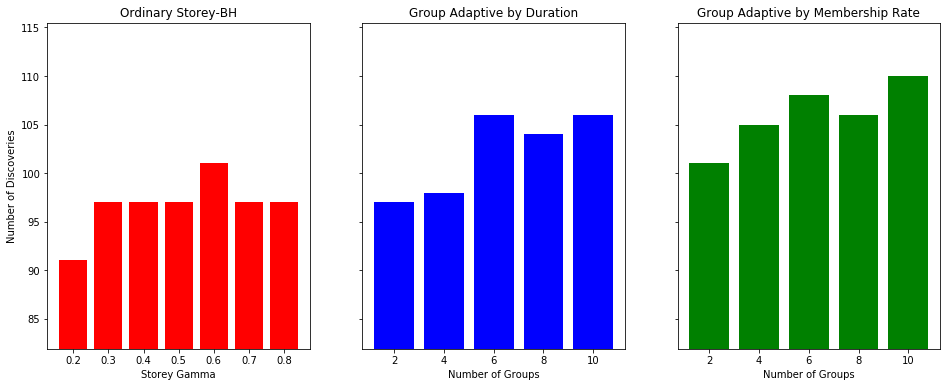

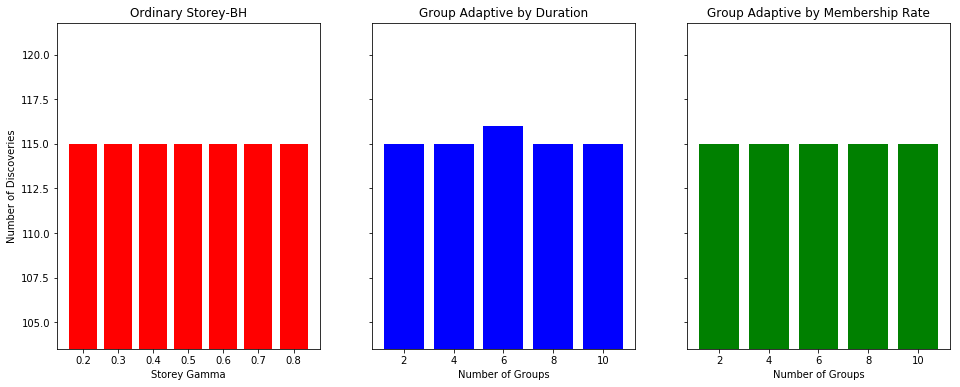

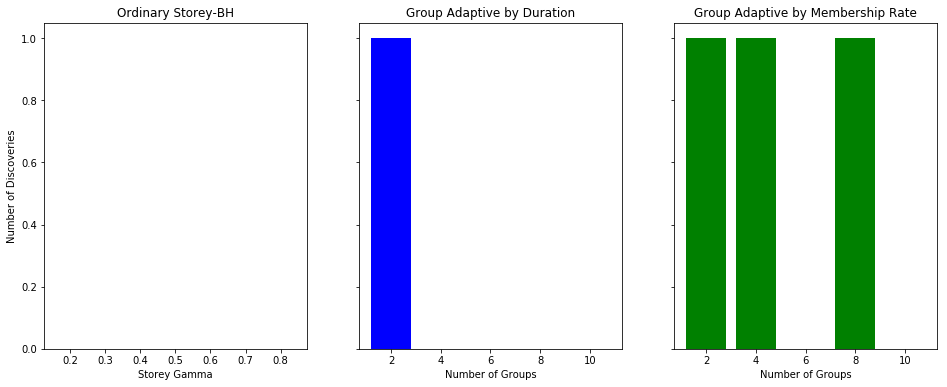

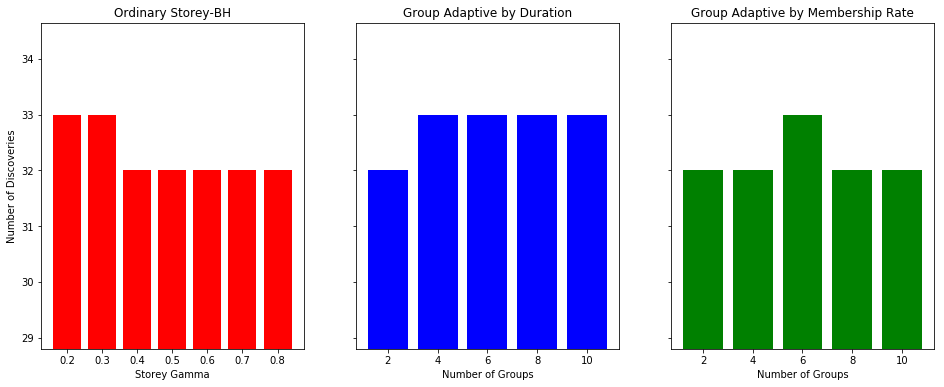

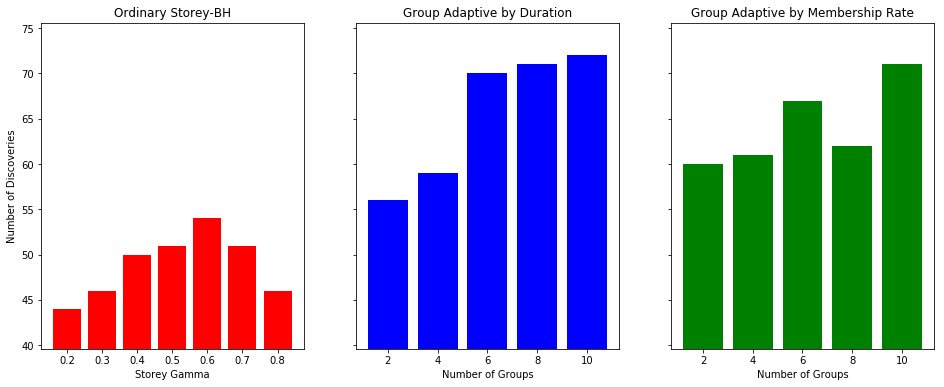

In [15]:

#print(pv_dict['31708'])
analyze_results(results)
#print(results, pv_dicts)



Text(0.5, 1.0, 'P-Value Histogram')

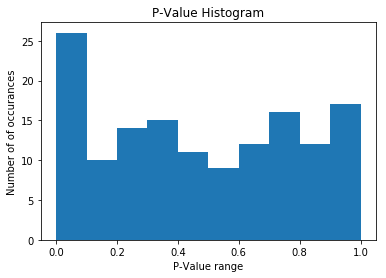

In [16]:
# We want a histogram for exp_num=2, where we made no discoveries

pv_dict = obtain_pvalues(exp_num=2, train_bool=train_bool)
pvlist = [p for _,p in pv_dict.items()]
plt.hist(pvlist)
plt.xlabel("P-Value range")
plt.ylabel("Number of of occurances")
plt.title("P-Value Histogram")


In [17]:
def parse_loc_data(rejections, i):
    
    with open("location_data.csv") as csvfile:
        rows = [row for row in csv.DictReader(csvfile)]
    print(rejections)
    results = []
    for row in rows:
        rej = bool(str(row["Station.num"]) in rejections)
        #print(rej, str(row["Station.num"]))
        result = [row["Latitude"], row["Longitude"], str(rej)] 
        results.append(result)
    
    with open("loc_coords_{}.csv".format((i)), "w+") as outfile:
        wrt = csv.writer(outfile, quoting=csv.QUOTE_NONE)
        wrt.writerow(["Lat", "Lon", "Rejected"])
        for result in results:
            wrt.writerow(result)
#parse_loc_data()

In [18]:
# Set true to output csv for maps
if True:
    rejections = [] 
    # exp1: extreme temp
    # exp1, ord bh, gamma=.4
    # exp1, duration gps, ngp = 6

    #rejections.append(results[0][2])
    #rejections.append(results[0][9])
    
    # exp5: percip
    # exp5, ord bh, gamma=.5
    # exp5, member gps, ngp = 6

    #rejections.append(results[4][3])
    #rejections.append(results[4][14])

    # exp 4: weekend weekday
    rejections.append(results[3][3])
    rejections.append(results[3][9])
    for i,r in enumerate(rejections):
        parse_loc_data(r, str(i))


['31007', '31009', '31011', '31012', '31100', '31204', '31205', '31206', '31207', '31212', '31213', '31216', '31220', '31221', '31224', '31227', '31233', '31238', '31262', '31266', '31301', '31505', '31623', '31624', '31801', '31802', '31804', '31218', '31603', '31208', '31620', '31052']
['31007', '31011', '31012', '31205', '31206', '31212', '31227', '31233', '31266', '31624', '31801', '31802', '31804', '31009', '31100', '31204', '31207', '31213', '31216', '31220', '31221', '31224', '31238', '31262', '31301', '31505', '31623', '31218', '31603', '31208', '31620', '31052', '31000']
